In this homework you'll train a simple image classifier using using Pytorch. If you're not familiar with Pytorch please take a look at our [introduction to Pytorch notebook](https://colab.research.google.com/drive/1GO_YSErd9TjiH0R-hZ2XkKIfMbQK9Ask?usp=sharing). There are four parts to the homework:

1. Dataset class: you'll create a custom dataset class that you'll use to load the images for training. Your image transformations should be done in the dataset class.

2. Model design: in this section you'll design a simple CNN based model architecture to learn to predict image classes correctly.

3. Model training: train an image classifier using the model you designed in step 2. You'll need to instantiate a dataloader that uses an instance of your dataset class to iterate through the dataset for training.

4. Evaluation: load your model's weight and run inference on the dataset and report your result

In [1]:
import os
import tarfile

# if not os.path.isfile('./data.tar.gz'):
#     !wget 'http://cs.umd.edu/~pulkit/hw_3_data.tar.gz' -O data.tar.gz

with tarfile.open('hw_3_data.tar', 'r:gz') as tar:
    tar.extractall(path='./')


### Dataset class

In [2]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import cv2
import os

class CustomImageDataset(Dataset):
    def __init__(self, csv_path, data_root, transform=None, device='cpu'):
        self.transform = transform
        self.root_path = data_root
        self.device = device

        # TODO: Read the csv file. You can use the pandas library
        data = pd.read_csv(csv_path)

        # TODO : Get the image paths from the csv
        self.image_paths = data['image_path']

        # TODO: Get the class ids from the csv. You might want to check if the class_id
        # column exists in the csv before trying to get it. The test csv does not have
        # the class_id column
        self.class_ids = data['class_id'] if 'class_id' in data else None

        # TODO: Get the image names from the csv. This is required for the test part at
        # the end of the notebook. You should only return the image name for testing,
        # otherwise you should return the image and the class id
        self.image_names = data['image_name']

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx: int):
        rel_img_path = self.image_paths[idx]
        image_name = self.image_names[idx]

        # TODO: Read the image file
        img = cv2.imread(self.root_path + rel_img_path)

        # TODO Apply transformations if any to the image. You will want to at least convert
        # the image to a tensor. You can also apply other transformations.
        img = self.transform(img)

        if self.class_ids is None: # for testing purposes
            return img, image_name, rel_img_path
        else:
            class_id = torch.tensor(self.class_ids[idx], dtype=torch.long)
            return img.to(self.device), class_id.to(self.device)

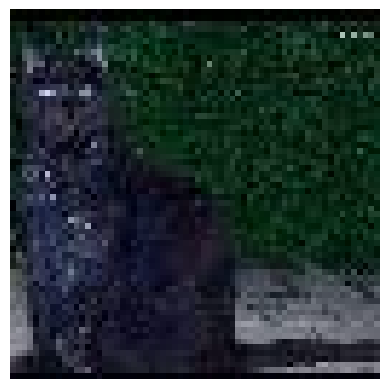

torch.Size([64, 64, 3])


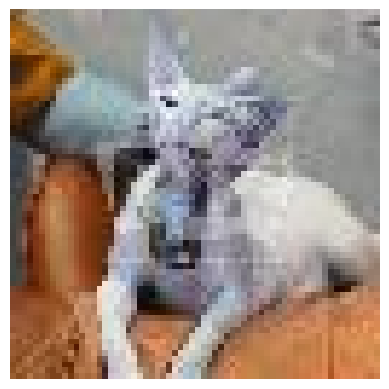

torch.Size([64, 64, 3])


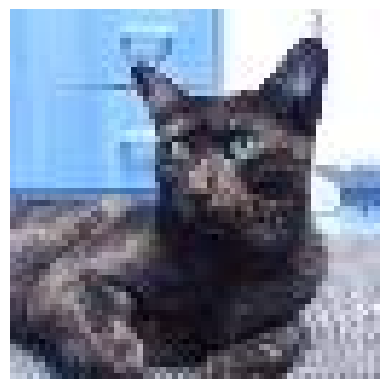

torch.Size([64, 64, 3])


In [3]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.transforms as T

def plot_image(img, title=None):
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


# TODO: Create an instance of the CustomImageDataset class for the training dataset
tfs = T.Compose([
    T.ToTensor()
])

dataset = CustomImageDataset(
    csv_path='data\\csvs\\train.csv',
    data_root='C:\\Users\\savag\\Documents\\temp_code\\cmsc421\\',
    transform=tfs)

# TODO: Show the first 3 images from the dataset
for i in range(3):
  plot_image((dataset.__getitem__(i)[0]).permute(1,2,0))
  print((dataset.__getitem__(i)[0]).permute(1,2,0).shape)

### Model definition

Define your image classifier model here. Since we're working with images, you should consider an convolution neural network type model architecture. Start simple and make it more complex if you need to once you have something working.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        # TODO: Create one or more convolutional neural network layers. This is just a suggestion.
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)

        # TODO: Create one or more feed forward layers. This is just a suggestion.
        self.ff = nn.Linear(32768, 4096)
        self.ff1 = nn.Linear(4096, 512)
        self.ff2 = nn.Linear(512, 10)
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.ff(x))
        x = self.dropout(x)
        x = F.relu(self.ff1(x))
        x = self.dropout(x)
        x = self.ff2(x)
        return x

### Training

In [5]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import Adam
import torchvision.transforms as T
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Feel free to try other batch sizes. The batch size is usually a power of 2.
batch_size = 16

# You can try other learning rates to see how it affects the training.
learning_rate = 1e-4

# Try to explore different transformation functions. You can use transformations
# to make your model more robust to translation, color changes etc. This is a good
# article that explains some transformations available in Pytorch
# https://pytorch.org/vision/stable/transforms.html. You can use transformations
# to augment/"increase" your training data.
transform = T.Compose([
    T.ToTensor(),
    T.RandomResizedCrop(size=(128, 128), antialias=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img_root = "./"

# TODO: Create an instance of the CustomImageDataset class for the training and validation datasets
train_set = CustomImageDataset(
    csv_path='data\\csvs\\train.csv',
    data_root='C:\\Users\\savag\\Documents\\temp_code\\cmsc421\\',
    transform=transform)
val_set = CustomImageDataset(
    csv_path='data\\csvs\\val.csv',
    data_root='C:\\Users\\savag\\Documents\\temp_code\\cmsc421\\',
    transform=transform)

# TODO: Create two dataloaders for bothe datasets.
# TODO: Shuffle the training dataloader. This is important to prevent the model from learning the order of the data.
train_loader = DataLoader(train_set, batch_size, shuffle=True)
val_loader = DataLoader(train_set, batch_size, shuffle=True)

# TODO: Initialize your model
n_classes = 10
model = ImageClassifier(n_classes=n_classes).to(device)

# TODO: Initialize the optimizer. Feel free to try other optimizers in the torch.optim
# module.
# Hint: the Adam optimizer and its variants are the staple these days.
optimizer = Adam(model.parameters(), lr=learning_rate)

# TODO: Instantiate the loss function.
# Hint: Cross entropy loss works great for classification tasks like this one.
# Reading up on what loss function to use for what task could be informative
loss_fn = nn.CrossEntropyLoss()

# Training loop
eval_every = 2

# Consider training for longer. Keep an eye on the validation loss and decide
# on what works best for you.
n_epochs = 300
val_loss_values = []
training_loss_values = []
eval_epochs = []

for epoch in range(n_epochs):
    # set your model to training mode. This is important if you're using normalization
    # or dropout
    model.train()
    for img, label in tqdm(train_loader):
        # zero the parameter gradients
        optimizer.zero_grad()

        # TODO: Make a forward pass (predict the class of the image)
        pred = model(img.to(device))

        # Calculate the loss
        loss = loss_fn(pred, label.to(device))

        loss.backward()
        optimizer.step()

    # Validation loop
    if epoch > 0 and epoch % eval_every == 0:
        model.eval()
        # don't calculate gradients when evaluating your model
        with torch.no_grad():
            for img, label in tqdm(val_loader):
                pred = model(img.to(device))
                val_loss = loss_fn(pred, label.to(device))

        print(f"Epoch: {epoch}, Train Loss: {loss.item()} Eval Loss: {val_loss.item()}")
        eval_epochs.append(epoch)
        training_loss_values.append(loss.item())
        val_loss_values.append(val_loss.item())


# Save your model's weights
torch.save(model.state_dict(), "model.pth")

100%|██████████| 188/188 [00:02<00:00, 63.05it/s]


Epoch: 2, Train Loss: 1.0224605798721313 Eval Loss: 1.8271205425262451


100%|██████████| 188/188 [00:02<00:00, 63.49it/s]


Epoch: 4, Train Loss: 1.8000140190124512 Eval Loss: 1.3833099603652954


100%|██████████| 188/188 [00:02<00:00, 64.27it/s]


Epoch: 6, Train Loss: 1.5445430278778076 Eval Loss: 0.38570544123649597


100%|██████████| 188/188 [00:03<00:00, 61.32it/s]


Epoch: 8, Train Loss: 0.8381032347679138 Eval Loss: 1.6613247394561768


100%|██████████| 188/188 [00:03<00:00, 62.52it/s]


Epoch: 10, Train Loss: 1.7214462757110596 Eval Loss: 1.6681724786758423


100%|██████████| 188/188 [00:02<00:00, 63.92it/s]


Epoch: 12, Train Loss: 0.7651699185371399 Eval Loss: 1.4894835948944092


100%|██████████| 188/188 [00:02<00:00, 66.08it/s]


Epoch: 14, Train Loss: 0.8591197729110718 Eval Loss: 0.9249752759933472


100%|██████████| 188/188 [00:02<00:00, 67.44it/s]


Epoch: 16, Train Loss: 1.0589734315872192 Eval Loss: 1.1145799160003662


100%|██████████| 188/188 [00:02<00:00, 66.48it/s]


Epoch: 18, Train Loss: 0.9593894481658936 Eval Loss: 0.5839590430259705


100%|██████████| 188/188 [00:02<00:00, 65.57it/s]


Epoch: 20, Train Loss: 0.6389538645744324 Eval Loss: 0.8869855999946594


100%|██████████| 188/188 [00:02<00:00, 66.21it/s]


Epoch: 22, Train Loss: 1.9733458757400513 Eval Loss: 0.4471767544746399


100%|██████████| 188/188 [00:02<00:00, 64.84it/s]


Epoch: 24, Train Loss: 0.8569190502166748 Eval Loss: 0.5003250241279602


100%|██████████| 188/188 [00:02<00:00, 65.09it/s]


Epoch: 26, Train Loss: 2.278815507888794 Eval Loss: 0.7726899981498718


100%|██████████| 188/188 [00:02<00:00, 66.98it/s]


Epoch: 28, Train Loss: 0.9448072910308838 Eval Loss: 1.2424031496047974


100%|██████████| 188/188 [00:02<00:00, 64.06it/s]


Epoch: 30, Train Loss: 1.3145052194595337 Eval Loss: 0.7477155923843384


100%|██████████| 188/188 [00:02<00:00, 65.15it/s]


Epoch: 32, Train Loss: 1.8854401111602783 Eval Loss: 0.5384589433670044


100%|██████████| 188/188 [00:02<00:00, 64.82it/s]


Epoch: 34, Train Loss: 0.6203349828720093 Eval Loss: 0.3977656960487366


100%|██████████| 188/188 [00:02<00:00, 66.62it/s]


Epoch: 36, Train Loss: 0.6511590480804443 Eval Loss: 0.7347208261489868


100%|██████████| 188/188 [00:02<00:00, 63.28it/s]


Epoch: 38, Train Loss: 1.292468547821045 Eval Loss: 0.8877043128013611


100%|██████████| 188/188 [00:02<00:00, 66.97it/s]


Epoch: 40, Train Loss: 0.6897361874580383 Eval Loss: 0.9159407615661621


100%|██████████| 188/188 [00:02<00:00, 67.18it/s]


Epoch: 42, Train Loss: 0.3976086378097534 Eval Loss: 1.0435209274291992


100%|██████████| 188/188 [00:02<00:00, 67.14it/s]


Epoch: 44, Train Loss: 0.7552415728569031 Eval Loss: 1.2822399139404297


100%|██████████| 188/188 [00:02<00:00, 66.02it/s]


Epoch: 46, Train Loss: 0.2732981741428375 Eval Loss: 0.8311488032341003


100%|██████████| 188/188 [00:02<00:00, 66.56it/s]


Epoch: 48, Train Loss: 0.6256353855133057 Eval Loss: 0.7365326881408691


100%|██████████| 188/188 [00:02<00:00, 66.03it/s]


Epoch: 50, Train Loss: 0.49458375573158264 Eval Loss: 0.8595496416091919


100%|██████████| 188/188 [00:02<00:00, 66.74it/s]


Epoch: 52, Train Loss: 0.4029768705368042 Eval Loss: 0.5504266023635864


100%|██████████| 188/188 [00:02<00:00, 67.10it/s]


Epoch: 54, Train Loss: 0.46699416637420654 Eval Loss: 0.6659964323043823


100%|██████████| 188/188 [00:02<00:00, 63.92it/s]


Epoch: 56, Train Loss: 0.6076818704605103 Eval Loss: 0.225603848695755


100%|██████████| 188/188 [00:02<00:00, 66.58it/s]


Epoch: 58, Train Loss: 0.14821672439575195 Eval Loss: 0.4895671010017395


100%|██████████| 188/188 [00:02<00:00, 67.08it/s]


Epoch: 60, Train Loss: 0.4197999835014343 Eval Loss: 0.5398428440093994


100%|██████████| 188/188 [00:02<00:00, 66.50it/s]


Epoch: 62, Train Loss: 0.15249362587928772 Eval Loss: 0.3824132978916168


100%|██████████| 188/188 [00:02<00:00, 66.70it/s]


Epoch: 64, Train Loss: 0.9628268480300903 Eval Loss: 0.9510013461112976


100%|██████████| 188/188 [00:02<00:00, 66.54it/s]


Epoch: 66, Train Loss: 0.2758672833442688 Eval Loss: 0.4342041611671448


100%|██████████| 188/188 [00:03<00:00, 61.59it/s]


Epoch: 68, Train Loss: 0.7507824897766113 Eval Loss: 0.43343472480773926


100%|██████████| 188/188 [00:02<00:00, 66.88it/s]


Epoch: 70, Train Loss: 0.42699068784713745 Eval Loss: 0.1104477047920227


100%|██████████| 188/188 [00:02<00:00, 65.98it/s]


Epoch: 72, Train Loss: 0.22361832857131958 Eval Loss: 0.7616895437240601


100%|██████████| 188/188 [00:02<00:00, 66.88it/s]


Epoch: 74, Train Loss: 1.1366040706634521 Eval Loss: 0.13086290657520294


100%|██████████| 188/188 [00:02<00:00, 67.14it/s]


Epoch: 76, Train Loss: 0.2857404053211212 Eval Loss: 0.05618736520409584


100%|██████████| 188/188 [00:02<00:00, 65.62it/s]


Epoch: 78, Train Loss: 1.139399766921997 Eval Loss: 0.158646821975708


100%|██████████| 188/188 [00:02<00:00, 66.25it/s]


Epoch: 80, Train Loss: 0.22910697758197784 Eval Loss: 0.44685959815979004


100%|██████████| 188/188 [00:02<00:00, 66.05it/s]


Epoch: 82, Train Loss: 0.42139795422554016 Eval Loss: 0.5087661147117615


100%|██████████| 188/188 [00:02<00:00, 67.35it/s]


Epoch: 84, Train Loss: 0.4817107915878296 Eval Loss: 0.8086322546005249


100%|██████████| 188/188 [00:02<00:00, 66.99it/s]


Epoch: 86, Train Loss: 1.893413782119751 Eval Loss: 0.25552067160606384


100%|██████████| 188/188 [00:02<00:00, 66.48it/s]


Epoch: 88, Train Loss: 0.11774519830942154 Eval Loss: 0.06077789142727852


100%|██████████| 188/188 [00:02<00:00, 65.73it/s]


Epoch: 90, Train Loss: 0.06658800691366196 Eval Loss: 0.23656588792800903


100%|██████████| 188/188 [00:02<00:00, 66.22it/s]


Epoch: 92, Train Loss: 0.09063924849033356 Eval Loss: 0.2737460136413574


100%|██████████| 188/188 [00:02<00:00, 65.69it/s]


Epoch: 94, Train Loss: 0.4778314232826233 Eval Loss: 0.0799870565533638


100%|██████████| 188/188 [00:02<00:00, 66.06it/s]


Epoch: 96, Train Loss: 0.8167346715927124 Eval Loss: 0.7921746373176575


100%|██████████| 188/188 [00:02<00:00, 66.60it/s]


Epoch: 98, Train Loss: 0.18794050812721252 Eval Loss: 0.2973775267601013


100%|██████████| 188/188 [00:02<00:00, 65.56it/s]


Epoch: 100, Train Loss: 0.37113237380981445 Eval Loss: 0.5214830040931702


100%|██████████| 188/188 [00:02<00:00, 66.11it/s]


Epoch: 102, Train Loss: 0.45759060978889465 Eval Loss: 0.49360793828964233


100%|██████████| 188/188 [00:02<00:00, 66.72it/s]


Epoch: 104, Train Loss: 0.2806107699871063 Eval Loss: 0.15118670463562012


100%|██████████| 188/188 [00:02<00:00, 65.94it/s]


Epoch: 106, Train Loss: 0.18210512399673462 Eval Loss: 0.5071902871131897


100%|██████████| 188/188 [00:02<00:00, 65.92it/s]


Epoch: 108, Train Loss: 1.029594898223877 Eval Loss: 1.0299410820007324


100%|██████████| 188/188 [00:02<00:00, 66.71it/s]


Epoch: 110, Train Loss: 0.23433555662631989 Eval Loss: 0.07604758441448212


100%|██████████| 188/188 [00:02<00:00, 67.55it/s]


Epoch: 112, Train Loss: 0.19445163011550903 Eval Loss: 0.6138168573379517


100%|██████████| 188/188 [00:02<00:00, 67.54it/s]


Epoch: 114, Train Loss: 0.7135031819343567 Eval Loss: 0.22196374833583832


100%|██████████| 188/188 [00:02<00:00, 67.07it/s]


Epoch: 116, Train Loss: 0.08110760897397995 Eval Loss: 0.0506572425365448


100%|██████████| 188/188 [00:02<00:00, 65.72it/s]


Epoch: 118, Train Loss: 0.1259457916021347 Eval Loss: 0.029770707711577415


100%|██████████| 188/188 [00:02<00:00, 66.44it/s]


Epoch: 120, Train Loss: 0.027745980769395828 Eval Loss: 0.12175660580396652


100%|██████████| 188/188 [00:02<00:00, 66.12it/s]


Epoch: 122, Train Loss: 0.49923235177993774 Eval Loss: 0.3111230731010437


100%|██████████| 188/188 [00:02<00:00, 67.44it/s]


Epoch: 124, Train Loss: 1.0109821557998657 Eval Loss: 0.26932191848754883


100%|██████████| 188/188 [00:02<00:00, 67.55it/s]


Epoch: 126, Train Loss: 0.568528950214386 Eval Loss: 0.05573780834674835


100%|██████████| 188/188 [00:02<00:00, 65.77it/s]


Epoch: 128, Train Loss: 0.2137758731842041 Eval Loss: 0.08942731469869614


100%|██████████| 188/188 [00:02<00:00, 67.00it/s]


Epoch: 130, Train Loss: 0.1481262743473053 Eval Loss: 0.41005051136016846


100%|██████████| 188/188 [00:02<00:00, 67.55it/s]


Epoch: 132, Train Loss: 0.6273276805877686 Eval Loss: 0.4845210015773773


100%|██████████| 188/188 [00:02<00:00, 65.91it/s]


Epoch: 134, Train Loss: 0.05174345523118973 Eval Loss: 0.18361128866672516


100%|██████████| 188/188 [00:02<00:00, 66.58it/s]


Epoch: 136, Train Loss: 0.4910202920436859 Eval Loss: 0.4161394536495209


100%|██████████| 188/188 [00:02<00:00, 66.54it/s]


Epoch: 138, Train Loss: 0.5762295722961426 Eval Loss: 0.0659046471118927


100%|██████████| 188/188 [00:02<00:00, 66.18it/s]


Epoch: 140, Train Loss: 0.01153002679347992 Eval Loss: 0.10805799067020416


100%|██████████| 188/188 [00:02<00:00, 67.74it/s]


Epoch: 142, Train Loss: 0.033006247133016586 Eval Loss: 0.5099305510520935


100%|██████████| 188/188 [00:02<00:00, 66.84it/s]


Epoch: 144, Train Loss: 0.14932337403297424 Eval Loss: 0.11153761297464371


100%|██████████| 188/188 [00:02<00:00, 66.89it/s]


Epoch: 146, Train Loss: 0.9671769738197327 Eval Loss: 0.05203203111886978


100%|██████████| 188/188 [00:02<00:00, 65.44it/s]


Epoch: 148, Train Loss: 0.5502607226371765 Eval Loss: 0.10225272178649902


100%|██████████| 188/188 [00:02<00:00, 65.81it/s]


Epoch: 150, Train Loss: 0.14913831651210785 Eval Loss: 0.9052547216415405


100%|██████████| 188/188 [00:02<00:00, 66.84it/s]


Epoch: 152, Train Loss: 0.3197189271450043 Eval Loss: 0.024096505716443062


100%|██████████| 188/188 [00:02<00:00, 65.25it/s]


Epoch: 154, Train Loss: 0.38818782567977905 Eval Loss: 0.23018312454223633


100%|██████████| 188/188 [00:02<00:00, 66.50it/s]


Epoch: 156, Train Loss: 0.5487111806869507 Eval Loss: 0.4913221001625061


100%|██████████| 188/188 [00:02<00:00, 66.62it/s]


Epoch: 158, Train Loss: 0.9968817234039307 Eval Loss: 0.03400656580924988


100%|██████████| 188/188 [00:03<00:00, 61.29it/s]


Epoch: 160, Train Loss: 0.48699840903282166 Eval Loss: 0.5531919002532959


100%|██████████| 188/188 [00:02<00:00, 63.40it/s]


Epoch: 162, Train Loss: 0.3883059322834015 Eval Loss: 0.4283582270145416


100%|██████████| 188/188 [00:02<00:00, 66.07it/s]


Epoch: 164, Train Loss: 0.07166431844234467 Eval Loss: 0.17317652702331543


100%|██████████| 188/188 [00:02<00:00, 65.81it/s]


Epoch: 166, Train Loss: 0.09761067479848862 Eval Loss: 0.3005334436893463


100%|██████████| 188/188 [00:03<00:00, 61.85it/s]


Epoch: 168, Train Loss: 0.12477313727140427 Eval Loss: 0.17347560822963715


100%|██████████| 188/188 [00:02<00:00, 64.48it/s]


Epoch: 170, Train Loss: 1.1519334316253662 Eval Loss: 0.814876139163971


100%|██████████| 188/188 [00:02<00:00, 65.89it/s]


Epoch: 172, Train Loss: 0.0801740288734436 Eval Loss: 0.012121176347136497


100%|██████████| 188/188 [00:02<00:00, 65.37it/s]


Epoch: 174, Train Loss: 0.1870248168706894 Eval Loss: 0.008941282518208027


100%|██████████| 188/188 [00:02<00:00, 65.92it/s]


Epoch: 176, Train Loss: 0.13574452698230743 Eval Loss: 0.047271303832530975


100%|██████████| 188/188 [00:02<00:00, 66.79it/s]


Epoch: 178, Train Loss: 1.3489210605621338 Eval Loss: 0.01117724273353815


100%|██████████| 188/188 [00:02<00:00, 65.78it/s]


Epoch: 180, Train Loss: 0.1511470079421997 Eval Loss: 0.1457640826702118


100%|██████████| 188/188 [00:02<00:00, 65.12it/s]


Epoch: 182, Train Loss: 0.04603799059987068 Eval Loss: 0.3583373427391052


100%|██████████| 188/188 [00:02<00:00, 66.58it/s]


Epoch: 184, Train Loss: 0.2294718474149704 Eval Loss: 0.014305757358670235


100%|██████████| 188/188 [00:02<00:00, 65.48it/s]


Epoch: 186, Train Loss: 0.24312840402126312 Eval Loss: 0.13710197806358337


100%|██████████| 188/188 [00:02<00:00, 63.08it/s]


Epoch: 188, Train Loss: 0.11263924837112427 Eval Loss: 0.4870074391365051


100%|██████████| 188/188 [00:02<00:00, 65.40it/s]


Epoch: 190, Train Loss: 0.18742769956588745 Eval Loss: 0.012026880867779255


100%|██████████| 188/188 [00:02<00:00, 64.94it/s]


Epoch: 192, Train Loss: 0.12193892151117325 Eval Loss: 0.07212796062231064


100%|██████████| 188/188 [00:02<00:00, 64.62it/s]


Epoch: 194, Train Loss: 0.09035251289606094 Eval Loss: 0.1525885909795761


100%|██████████| 188/188 [00:02<00:00, 65.35it/s]


Epoch: 196, Train Loss: 0.06042462959885597 Eval Loss: 0.7881406545639038


100%|██████████| 188/188 [00:02<00:00, 65.66it/s]


Epoch: 198, Train Loss: 0.0378696508705616 Eval Loss: 0.5686196088790894


100%|██████████| 188/188 [00:02<00:00, 65.35it/s]


Epoch: 200, Train Loss: 0.22102363407611847 Eval Loss: 0.0012293723411858082


100%|██████████| 188/188 [00:02<00:00, 65.66it/s]


Epoch: 202, Train Loss: 0.5846487879753113 Eval Loss: 0.18134605884552002


100%|██████████| 188/188 [00:02<00:00, 64.58it/s]


Epoch: 204, Train Loss: 0.38316965103149414 Eval Loss: 0.37323883175849915


100%|██████████| 188/188 [00:02<00:00, 65.15it/s]


Epoch: 206, Train Loss: 0.011325323022902012 Eval Loss: 0.3945077061653137


100%|██████████| 188/188 [00:02<00:00, 66.19it/s]


Epoch: 208, Train Loss: 0.2560001015663147 Eval Loss: 0.22339017689228058


100%|██████████| 188/188 [00:02<00:00, 65.16it/s]


Epoch: 210, Train Loss: 0.06725087761878967 Eval Loss: 0.5927059650421143


100%|██████████| 188/188 [00:02<00:00, 66.48it/s]


Epoch: 212, Train Loss: 0.08307859301567078 Eval Loss: 0.13491538166999817


100%|██████████| 188/188 [00:02<00:00, 63.99it/s]


Epoch: 214, Train Loss: 0.4411575198173523 Eval Loss: 0.2864502966403961


100%|██████████| 188/188 [00:02<00:00, 64.50it/s]


Epoch: 216, Train Loss: 0.13240861892700195 Eval Loss: 0.22134707868099213


100%|██████████| 188/188 [00:02<00:00, 66.61it/s]


Epoch: 218, Train Loss: 0.08694790303707123 Eval Loss: 0.3432425558567047


100%|██████████| 188/188 [00:02<00:00, 64.14it/s]


Epoch: 220, Train Loss: 0.028880158439278603 Eval Loss: 0.07575902342796326


100%|██████████| 188/188 [00:02<00:00, 64.94it/s]


Epoch: 222, Train Loss: 0.019336450845003128 Eval Loss: 0.0777604728937149


100%|██████████| 188/188 [00:02<00:00, 66.72it/s]


Epoch: 224, Train Loss: 0.1293785274028778 Eval Loss: 0.05477066710591316


100%|██████████| 188/188 [00:02<00:00, 65.53it/s]


Epoch: 226, Train Loss: 0.4347996413707733 Eval Loss: 0.0534147247672081


100%|██████████| 188/188 [00:02<00:00, 65.32it/s]


Epoch: 228, Train Loss: 0.7438063621520996 Eval Loss: 0.39674973487854004


100%|██████████| 188/188 [00:02<00:00, 65.65it/s]


Epoch: 230, Train Loss: 0.1199648454785347 Eval Loss: 0.0023515026550740004


100%|██████████| 188/188 [00:02<00:00, 66.68it/s]


Epoch: 232, Train Loss: 0.4178374409675598 Eval Loss: 0.015370119363069534


100%|██████████| 188/188 [00:02<00:00, 66.11it/s]


Epoch: 234, Train Loss: 0.23562145233154297 Eval Loss: 0.007916131056845188


100%|██████████| 188/188 [00:02<00:00, 67.23it/s]


Epoch: 236, Train Loss: 0.11113308370113373 Eval Loss: 0.37698253989219666


100%|██████████| 188/188 [00:02<00:00, 66.05it/s]


Epoch: 238, Train Loss: 0.3996618390083313 Eval Loss: 0.03122638538479805


100%|██████████| 188/188 [00:02<00:00, 64.67it/s]


Epoch: 240, Train Loss: 0.3678131103515625 Eval Loss: 0.26876890659332275


100%|██████████| 188/188 [00:02<00:00, 66.39it/s]


Epoch: 242, Train Loss: 0.00984294805675745 Eval Loss: 0.35640597343444824


100%|██████████| 188/188 [00:02<00:00, 66.21it/s]


Epoch: 244, Train Loss: 0.0694945827126503 Eval Loss: 0.037086114287376404


100%|██████████| 188/188 [00:02<00:00, 64.95it/s]


Epoch: 246, Train Loss: 0.13818946480751038 Eval Loss: 0.0022537773475050926


100%|██████████| 188/188 [00:02<00:00, 66.55it/s]


Epoch: 248, Train Loss: 0.9747129082679749 Eval Loss: 0.0671859085559845


100%|██████████| 188/188 [00:02<00:00, 65.42it/s]


Epoch: 250, Train Loss: 0.48753979802131653 Eval Loss: 0.19199180603027344


100%|██████████| 188/188 [00:02<00:00, 65.35it/s]


Epoch: 252, Train Loss: 0.010911957360804081 Eval Loss: 0.09415187686681747


100%|██████████| 188/188 [00:02<00:00, 65.82it/s]


Epoch: 254, Train Loss: 0.0879589393734932 Eval Loss: 0.4371136426925659


100%|██████████| 188/188 [00:02<00:00, 66.35it/s]


Epoch: 256, Train Loss: 0.08056660741567612 Eval Loss: 0.23742513358592987


100%|██████████| 188/188 [00:02<00:00, 64.73it/s]


Epoch: 258, Train Loss: 1.08336341381073 Eval Loss: 0.11525961011648178


100%|██████████| 188/188 [00:02<00:00, 66.06it/s]


Epoch: 260, Train Loss: 0.32134518027305603 Eval Loss: 0.0005090029444545507


100%|██████████| 188/188 [00:02<00:00, 65.66it/s]


Epoch: 262, Train Loss: 0.13158556818962097 Eval Loss: 0.20410168170928955


100%|██████████| 188/188 [00:02<00:00, 65.50it/s]


Epoch: 264, Train Loss: 0.5942973494529724 Eval Loss: 0.0022655269131064415


100%|██████████| 188/188 [00:02<00:00, 65.04it/s]


Epoch: 266, Train Loss: 0.17869694530963898 Eval Loss: 0.00045083847362548113


100%|██████████| 188/188 [00:02<00:00, 66.44it/s]


Epoch: 268, Train Loss: 0.4972120225429535 Eval Loss: 0.17287597060203552


100%|██████████| 188/188 [00:02<00:00, 66.05it/s]


Epoch: 270, Train Loss: 0.32022732496261597 Eval Loss: 0.015356534160673618


100%|██████████| 188/188 [00:02<00:00, 64.49it/s]


Epoch: 272, Train Loss: 0.041305992752313614 Eval Loss: 0.5022146701812744


100%|██████████| 188/188 [00:02<00:00, 66.57it/s]


Epoch: 274, Train Loss: 0.47552749514579773 Eval Loss: 0.05040184035897255


100%|██████████| 188/188 [00:02<00:00, 66.26it/s]


Epoch: 276, Train Loss: 0.028917768970131874 Eval Loss: 0.24228231608867645


100%|██████████| 188/188 [00:02<00:00, 65.77it/s]


Epoch: 278, Train Loss: 0.10367631912231445 Eval Loss: 0.1604875773191452


100%|██████████| 188/188 [00:02<00:00, 65.78it/s]


Epoch: 280, Train Loss: 0.5578232407569885 Eval Loss: 1.3029248714447021


100%|██████████| 188/188 [00:02<00:00, 65.90it/s]


Epoch: 282, Train Loss: 0.4785212576389313 Eval Loss: 0.11974102258682251


100%|██████████| 188/188 [00:02<00:00, 65.15it/s]


Epoch: 284, Train Loss: 0.724410891532898 Eval Loss: 0.31101104617118835


100%|██████████| 188/188 [00:02<00:00, 66.22it/s]


Epoch: 286, Train Loss: 0.21123257279396057 Eval Loss: 0.23875707387924194


100%|██████████| 188/188 [00:02<00:00, 65.37it/s]


Epoch: 288, Train Loss: 0.08775800466537476 Eval Loss: 0.021790115162730217


100%|██████████| 188/188 [00:02<00:00, 64.94it/s]


Epoch: 290, Train Loss: 0.4697648286819458 Eval Loss: 0.020220190286636353


100%|██████████| 188/188 [00:02<00:00, 66.59it/s]


Epoch: 292, Train Loss: 0.5513536930084229 Eval Loss: 0.18779700994491577


100%|██████████| 188/188 [00:02<00:00, 65.03it/s]


Epoch: 294, Train Loss: 0.21307602524757385 Eval Loss: 0.09983019530773163


100%|██████████| 188/188 [00:02<00:00, 65.66it/s]


Epoch: 296, Train Loss: 0.12034571915864944 Eval Loss: 0.1405971646308899


100%|██████████| 188/188 [00:02<00:00, 65.99it/s]


Epoch: 298, Train Loss: 0.1476542055606842 Eval Loss: 0.1887226104736328


100%|██████████| 188/188 [00:07<00:00, 24.05it/s]


### Plot your training and validation loss

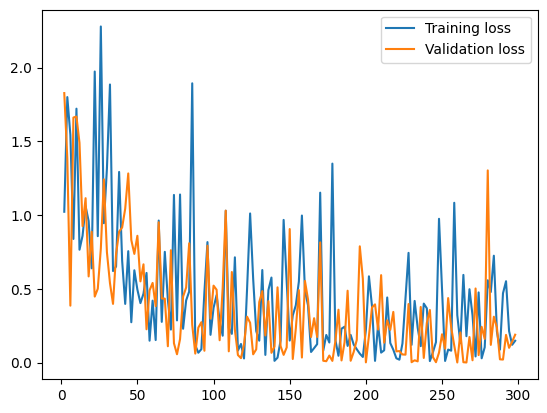

In [6]:
# Plot the training and validation loss
plt.plot(eval_epochs, training_loss_values, label='Training loss')
plt.plot(eval_epochs, val_loss_values, label='Validation loss')
plt.legend()
plt.show()

### Test your model against the validation dataset
This should give you a rough idea on how your model will do on the test set that you don't have labels for.
This section is not required and is only provided as a sanity check for you

In [7]:
## Load from your saved model
import numpy as np
import torch

# Load from your saved model using torch.load
model_state_dict = torch.load("./model.pth")
model = ImageClassifier(10).to(device)
model.load_state_dict(model_state_dict)

# set model to inference mode
model.eval()
batch_size = 1

# Load the validation dataset
test_dataset = CustomImageDataset(
    csv_path='data\\csvs\\val.csv',
    data_root='C:\\Users\\savag\\Documents\\temp_code\\cmsc421\\',
    transform=transform)
test_loader = DataLoader(test_dataset, batch_size)

preds = []
model.eval()
with torch.no_grad():
    for img, label in tqdm(test_loader):
        # TODO: predict the classes of the images and append them to the preds list
        preds.append(np.argmax(model(img.to(device)).cpu()).item())

# Get the true labels for the validation dataset
true_labels = torch.tensor(test_dataset.class_ids.values).to(device)
accuracy = (true_labels == torch.tensor(preds).to(device)).float().mean().item()
print(f"\nAccuracy: {accuracy}")

100%|██████████| 500/500 [00:03<00:00, 129.61it/s]


Accuracy: 0.6300000548362732


### Evaluation
Evaluate your model on the test dataset and create a CSF file. This is the file you need to submit.
> Important: make sure the prediction file has the columns: image_name, prediction, image_path

In [8]:
## Load from your saved model
import numpy as np
import torch

# Load from your saved model using torch.load
model_state_dict = torch.load("./model.pth")
model = ImageClassifier(10).to(device)
model.load_state_dict(model_state_dict)

# set model to inference mode
model.eval()

# Load the test data
test_dataset = CustomImageDataset(
    csv_path='data\\csvs\\test.csv',
    data_root='C:\\Users\\savag\\Documents\\temp_code\\cmsc421\\',
    transform=transform)

# TODO: Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size)

# TODO: Predict and save output to a CSV file. We are just looking for the top class predicted
# Hint: Lookup argmax.
final_preds = []

with torch.no_grad():
    for img, img_names, img_paths in tqdm(test_loader):
        pred = [np.argmax(model(img.to(device)).cpu()).item()]
        # For every element in the batch, get its predicted class id in `pred`
        # Class ID will be in int.
        batch_preds = [
            (img_name, pred_img, img_path)
            for (img_name, pred_img, img_path) in zip(img_names, pred, img_paths)
        ]
        final_preds.extend(batch_preds)

100%|██████████| 1500/1500 [00:21<00:00, 71.16it/s]


In [9]:
# DO NOT MODIFY
test_prediction = pd.DataFrame(final_preds, columns=['image_name', 'prediction', 'image_path'])
test_prediction.to_csv('prediction.csv')

# You can comment these lines out if you're running the notebook locally
# from google.colab import files
# files.download('prediction.csv')

Upload *prediction.csv* on gradescope